In [9]:
%reload_kedro

2023-03-16 09:50:55,248 - kedro.extras.extensions.ipython - INFO - No path argument was provided. Using: /Users/guilhermepalazzo/Desktop/dev/git_repositories/crypto_msc_thesis
2023-03-16 09:50:56,020 - kedro.framework.session.store - INFO - `read()` not implemented for `BaseSessionStore`. Assuming empty store.
2023-03-16 09:50:56,249 - kedro.extras.extensions.ipython - INFO - ** Kedro project crypto_thesis
2023-03-16 09:50:56,250 - kedro.extras.extensions.ipython - INFO - Defined global variable `context`, `session`, `catalog` and `pipelines`


In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
from crypto_thesis.data_domains.spine import spine_build_target_labels

In [11]:
plt.style.use("grayscale")

### Label balancing

In [12]:
df_spine_preproc = catalog.load("spine_preprocessing")
df_spine_logret = catalog.load("spine_log_ret")
spine_params = catalog.load("params:spine_labeling")

2023-03-16 09:50:57,367 - kedro.io.data_catalog - INFO - Loading data from `spine_preprocessing` (ParquetDataSet)...
2023-03-16 09:50:57,450 - kedro.io.data_catalog - INFO - Loading data from `spine_log_ret` (ParquetDataSet)...
2023-03-16 09:50:57,487 - kedro.io.data_catalog - INFO - Loading data from `params:spine_labeling` (MemoryDataSet)...


In [13]:
# test a different tau value to evaluate class balancing
# spine_params.update({"tau": 0.5})
# spine_params

In [14]:
df_spine_lbl = spine_build_target_labels(df=df_spine_preproc, 
                                         df_log_ret=df_spine_logret, 
                                         label_params=spine_params)

In [15]:
df_spine_lbl.label.value_counts() / df_spine_lbl.shape[0]

bottom    0.520869
top       0.479131
Name: label, dtype: float64

### Volume bar time interval plots

In [13]:
df_spine = catalog.load("spine_labeled")
df_ftes = catalog.load("fte_binance").dropna()

2023-03-15 15:04:34,008 - kedro.io.data_catalog - INFO - Loading data from `spine_labeled` (ParquetDataSet)...
2023-03-15 15:04:34,050 - kedro.io.data_catalog - INFO - Loading data from `fte_binance` (ParquetDataSet)...


In [15]:
df_spine_aux = df_spine.copy()

df_spine_aux = df_spine_aux.merge(df_ftes[["open_time", "close_time"]], \
                                  on=["open_time", "close_time"] , \
                                 how="inner")

df_spine_aux.loc[:, "open_close_durt_sec"] = (df_spine_aux["close_time"] - df_spine_aux["open_time"]).dt.total_seconds()
df_spine_aux.loc[:, "close_target_durt_sec"] = (df_spine_aux["target_time"] - df_spine_aux["close_time"]).dt.total_seconds()

df_spine_aux.loc[:, "open_close_durt_min"] = df_spine_aux["open_close_durt_sec"] / 60.0
df_spine_aux.loc[:, "close_target_durt_min"] = df_spine_aux["close_target_durt_sec"] / 60.0

In [16]:
df_spine_aux.head()

,open_time,close_time,target_time,logret_cumsum,target_time_close,target_time_log_return,close_time_close,std,close_to_tgt_time_logret,label,open_close_durt_sec,close_target_durt_sec,open_close_durt_min,close_target_durt_min
0,2019-11-28 08:30:00,2019-11-29 05:45:00,2019-11-29 21:45:00,-0.001806,7689.96,-0.000633,7461.79,0.003364,0.030120,top,76500.0,57600.0,1275.0,960.0
1,2019-11-29 06:00:00,2019-11-29 21:45:00,2019-12-01 00:15:00,0.030120,7489.00,-0.002034,7689.96,0.003001,-0.026480,bottom,56700.0,95400.0,945.0,1590.0
2,2019-11-29 22:00:00,2019-12-01 00:15:00,2019-12-01 17:45:00,-0.026480,7323.22,0.002091,7489.00,0.002813,-0.022385,top,94500.0,63000.0,1575.0,1050.0
3,2019-12-01 00:30:00,2019-12-01 17:45:00,2019-12-02 17:30:00,-0.022385,7295.00,0.003579,7323.22,0.003105,-0.003861,top,62100.0,85500.0,1035.0,1425.0
4,2019-12-01 18:00:00,2019-12-02 17:30:00,2019-12-04 01:45:00,-0.003861,7156.69,-0.001915,7295.00,0.002540,-0.019142,bottom,84600.0,116100.0,1410.0,1935.0


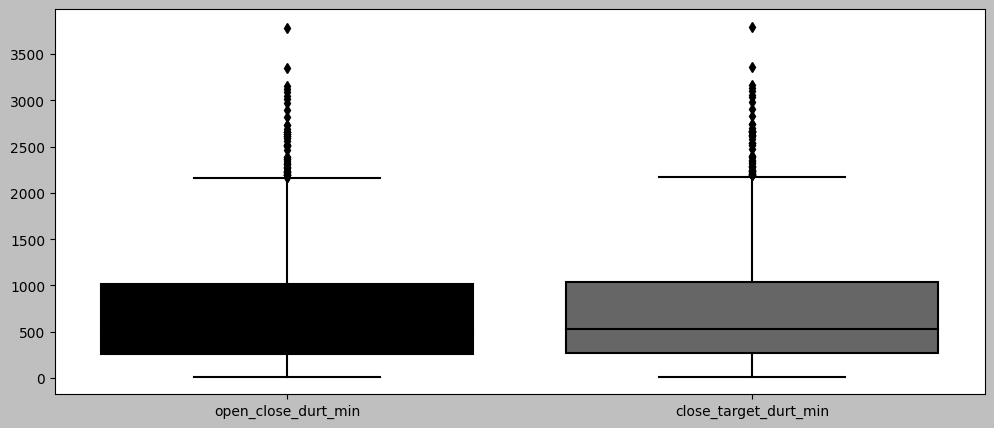

In [19]:
df_plot = df_spine_aux[["close_time", "open_close_durt_min", "close_target_durt_min"]] \
                        .set_index("close_time") \
                        .sort_index()

plt.figure(figsize=(12, 5))

plot = sns.boxplot(df_plot)

fig = plot.get_figure()
fig.savefig("/Users/guilhermepalazzo/Desktop/fig_boxplot_time_windows.png")

In [20]:
df_plot.describe()

,open_close_durt_min,close_target_durt_min
count,2310.000000,2310.000000
mean,705.642857,719.928571
std,578.841704,579.030908
min,15.000000,15.000000
25%,255.000000,270.000000
50%,510.000000,525.000000
75%,1020.000000,1035.000000
max,3780.000000,3795.000000
